In [1]:
import copy
import numpy as np
import sys

In [2]:
import analysis_config

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [5]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.executable_helpers as exec_helpers

In [6]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

# Load Data

In [7]:
default_sim = 'm10y'
default_snum = 172

In [8]:
sim_name, snum = exec_helpers.choose_config_or_commandline(
    [ default_sim, default_snum ]
)
print( 'Using sim {}, snum {}'.format( sim_name, snum ) )

Using sim m10y, snum 172


In [9]:
galdef = ''

In [10]:
file_manager = file_management.FileManager( 'CGM_fate' )

In [11]:
defaults = file_manager.get_linefinder_analysis_defaults(
    '_CGM_snum{}'.format( snum ),
    sim_name = sim_name,
    galdef = galdef
)

In [12]:
ind = defaults['ahf_index'] - snum

In [13]:
w = a_worldlines.Worldlines( **defaults )

In [14]:
w.retrieve_halo_data()

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [15]:
print( w.tag )

m10y_CGM_snum172


In [16]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print( plot_label )

$M_{\rm h} = 10^{9.5} M_\odot$, z=2.0


In [17]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )

In [18]:
w_plotter = p_worldlines.WorldlinesPlotter( w, label=plot_label )

In [19]:
g_data = particle_data.ParticleData(
    sdir = file_manager.get_sim_dir( sim_name ),
    snum = snum,
    ptype = config.PTYPE_GAS,
    halo_data_dir = file_manager.get_halo_dir( sim_name ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
)

In [20]:
g_plotter = generic_plotter.GenericPlotter(
    g_data,
    label=plot_label,
)

In [21]:
s_data = particle_data.ParticleData(
    sdir = file_manager.get_sim_dir( sim_name ),
    snum = snum,
    ptype = config.PTYPE_STAR,
    halo_data_dir = file_manager.get_halo_dir( sim_name ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],    
)

In [22]:
s_plotter = generic_plotter.GenericPlotter( s_data )

### Create a circle to plot

In [23]:
r_gal = w.r_gal[ind]

In [24]:
circle = []
for phi in np.linspace( 0., 2.*np.pi, 256 ):
    
    circle.append(
        [ r_gal*np.cos(phi), r_gal*np.sin(phi), 0. ]
    )
    
circle = np.array( circle )

rotated_circle = data_operations.align_axes( circle, s_data.total_ang_momentum, )

# Illustrative Plot

In [25]:
r_vir = w.r_vir.values[ind]

In [26]:
t_show_min = {
    465 : 0.5,
    172 : 0.25,
    214 : 0.25,
}
t_show_max = {
    465 : 1.0,
    172 : 0.5,
    214 : 0.5,
}

In [27]:
data_args = {
    465 : { 'smooth_data' : True, 'smoothing_window_length' : 21 },
    172 : { 'smooth_data' : True, 'smoothing_window_length' : 11 },
    214 : { 'smooth_data' : True, 'smoothing_window_length' : 21 },
}

is_CGM_still
is_CGM_accreted
is_CGM_ejected


is_CGM_accreted
is_CGM_ejected
File saved at /home1/03057/zhafen/papers/CGM_fate/figures/streamlines_m10y_CGM_snum172.png


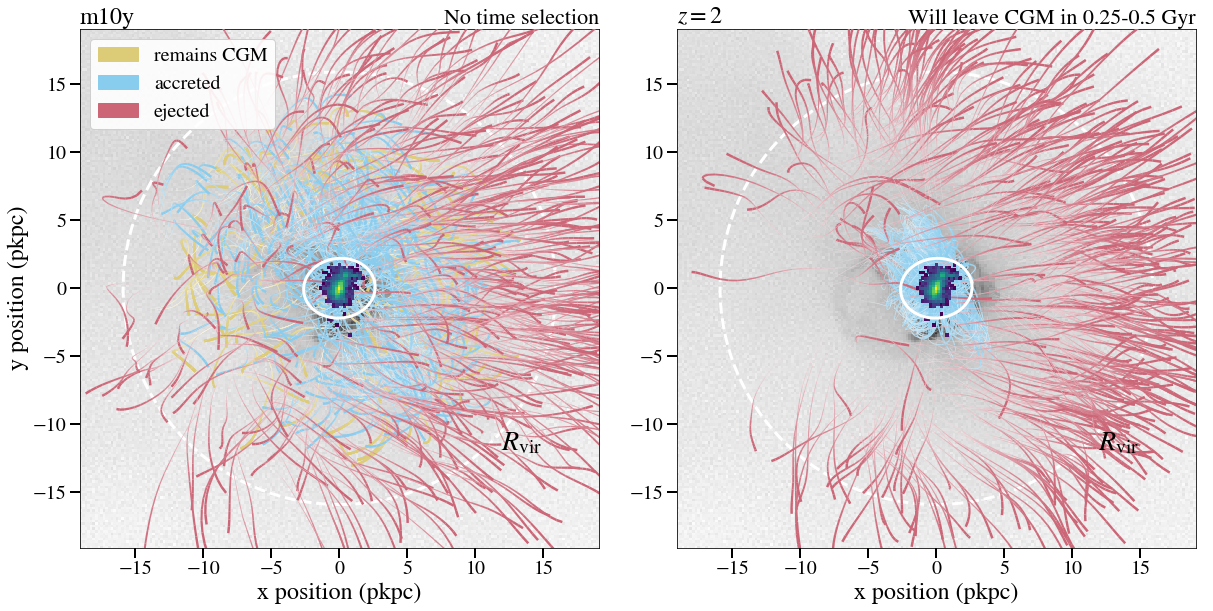

In [28]:
fig = plt.figure( figsize=(20,10), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( 1, 2 )
axs = [ plt.subplot( gs[0,0] ), plt.subplot( gs[0,1] ) ]

gs.update( wspace=0.15 )

plotted_range = [ -1.2*r_vir, 1.2*r_vir ]

x_axis = 'Rx'
y_axis = 'Ry'

for j, sample_selected_interval in enumerate( [ False, True ] ):
    
    ax = axs[j]
    
    labels = []
    color_objects = []
    for i, classification in enumerate( classification_list ):

        w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )
        
        # Don't plot CGM accreted-satellite for m10s, because there are just
        # too few particles
        if (
            classification == 'is_CGM_accreted_to_satellite' and
            config.MASS_BINS[sim_name] == 'm10'
        ):
            continue
        # Don't plot CGM accreted-satellite for m11s at high-z when applying the time cut, because there are just
        # too few particles
        if (
            classification == 'is_CGM_accreted_to_satellite' and
            config.MASS_BINS[sim_name] == 'm11' and
            ax.is_last_col() and
            snum == 172
        ):
            continue
            
        # Don't plot CGM still for m12s at high-z, because there are just
        # too few particles
        if (
            classification == 'is_CGM_still' and
            config.MASS_BINS[sim_name] != 'm10' and
            snum == 172
        ):
            continue
        
            
        # Don't plot halo transfer, as it's an unimportant component
        if classification == 'is_CGM_halo_transfer':
            continue
            
        # Don't plot CGM still when we're doing fates close to their exit time
        if classification == 'is_CGM_still' and sample_selected_interval:
            continue
        
        print( classification )
        w_plotter.plot_streamlines(
            x_axis,
            y_axis,
            ax = ax,
            classification = classification,
            classification_ind = ind,
            start_ind = 'time_based',
            end_ind = ind,
            t_start = t_show_max[snum],
            sample_size = 500,
            sample_selected_interval = sample_selected_interval,
            selected_interval_type = 'time_until_not',
            selected_interval_classification = 'is_in_CGM_or_interface',
            t_show_min = t_show_min[snum],
            t_show_max = t_show_max[snum],
            x_data_kwargs = data_args[snum],
            y_data_kwargs = data_args[snum],
            linewidth = 2.5,
            plot_halos = False,
#             plot_xlabel = ( sim_name == 'm10y' ),
            plot_ylabel = ax.is_first_col(),
            x_label = '{} position (pkpc)'.format( x_axis[1] ),
            y_label = '{} position (pkpc)'.format( y_axis[1] ),
            x_range = plotted_range,
            y_range = plotted_range,
            fontsize = 24,
        )

        # Make virtual artists to allow a legend to appear
        color_object = matplotlib.patches.Rectangle(                         
            (0, 0),                                                          
            1,                                                               
            1,                                                               
            fc = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
            ec = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
            alpha = p_constants.CLASSIFICATION_ALPHA,                        
        )                                                                    
        color_objects.append( color_object )                                 
        labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

    if j==0:
        plot_label = sim_name
    else:
        plot_label = r'$z = {:.2g}$'.format( g_data.redshift )
    vmaxes = {
        'm10' : 4e3,
        'm11' : 4e3,
        'm12' : 4e3,
    }
    vmax = vmaxes[config.MASS_BINS[sim_name]]
    g_plotter.histogram2d(
        x_axis,
        y_axis,
        cmap = cm.Greys,
        ax = ax,
        x_range = plotted_range,
        y_range = plotted_range,
        n_bins = 200,
#         vmin = 1,
        vmax = vmax,
        add_colorbar = False,
        add_x_label = False,
        add_y_label = False,
        label_fontsize = 24,
        plot_label = plot_label,
    )
    
    vmins = {
        172 : {
            'm10' : 10,
            'm11' : 10,
            'm12' : 20,
        },
        214 : {
            'm12' : 50,
        },
        465 : {
            'm10' : 20,
            'm11' : 20,
            'm12' : 5e2,
        },
    }
    vmin = vmins[snum][config.MASS_BINS[sim_name]]
    s_plotter.histogram2d(
        x_axis,
        y_axis,
        cmap = cm.viridis,
        ax = ax,
        x_range = plotted_range,
        y_range = plotted_range,
        n_bins = 200,
        vmin = vmin,
#         vmax = 4e3,
        plot_label = None,
        add_colorbar = False,
        add_x_label = False,
        add_y_label = False,
        label_fontsize = 20,
        zorder = 150,
        min_bin_value_displayed = vmin,
    )

#     s_plotter.scatter(
#         'Rx',
#         'Ry',
#         color = '#303030',
# #         color = '#e6e032',
#         marker = '*',
#         ax = ax,
#         x_range = plotted_range,
#         y_range = plotted_range,
#         n_subsample = 2000,
#         zorder = 150.,
#         plot_label = None,
#         add_x_label = False,
#         add_y_label = False,
#     )

    # Virial Radius circle
    cir = mpatches.Circle(
        [0, 0],
        radius = r_vir,
        linewidth = 3,
        color = 'w',
        linestyle = '--',
        fill = False,
        facecolor = 'w',
    )
    ax.add_patch( cir )
    ax.annotate(
        s = r'$R_{\rm vir}$',
        xy = ( .7475*r_vir, -.7475*r_vir ),
        xycoords = 'data',
        fontsize = 28,
        color = 'k',
        zorder = 150,
    )
    
    # Galaxy disk circle
    ax.plot(
        rotated_circle[:,0],
        rotated_circle[:,1],
        color = 'w',
        linewidth = 3,
        zorder = 200,
    )
    
    if ax.is_first_col():
        filter_label = 'No time selection'
    if ax.is_last_col():
        filter_label = 'Will leave CGM in {}-{} Gyr'.format(
            t_show_min[snum],
            t_show_max[snum],
        )
    ax.annotate(
        s = filter_label,
        xy = ( 1., 1. ),
        xycoords = 'axes fraction',
        va = 'bottom',
        ha = 'right',
        fontsize = 22,
    )

    if ax.is_first_col():
        leg = ax.legend(
            color_objects,
            labels,
            prop={'size': 20},
            ncol=1,
    #         loc=(0.65, 0.83),
            loc='upper left',
            fontsize=24,
            framealpha = 0.9,
        )
        leg.set_zorder( 200 )

    ax.set_aspect( 'equal' )

save_file = 'streamlines_{}.png'.format( defaults['tag'] )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
    resolution = 50,
)

fig

# Plot vs Time

In [29]:
w.data_masker.clear_masks()

In [30]:
# Set limits
y_max = np.nanpercentile( w.get_selected_data_over_time(
    data_key = 'R',
    snum = snum,
    classification = 'is_CGM_IGM_accretion',
)[:,0], 80. )*1.1
y_max = w.r_vir.values[0]*1.5

# Plot for Next Fate

In [31]:
used_classification_list = copy.copy( classification_list )
used_classification_list.remove( 'is_CGM_halo_transfer' )

In [32]:
# Don't plot CGM accreted-satellite for m10s at low-z when applying the time cut, because there are just
# too few particles
if (config.MASS_BINS[sim_name] == 'm10'):
    used_classification_list.remove( 'is_CGM_accreted_to_satellite' )
# Don't plot CGM still for m12s at high-z, because there are just
# too few particles
if (
    snum < 465 and
    config.MASS_BINS[sim_name] == 'm12'
):
    used_classification_list.remove( 'is_CGM_still' )

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


File saved at /home1/03057/zhafen/papers/CGM_fate/figures/r_vs_time_m10y_CGM_snum172.pdf


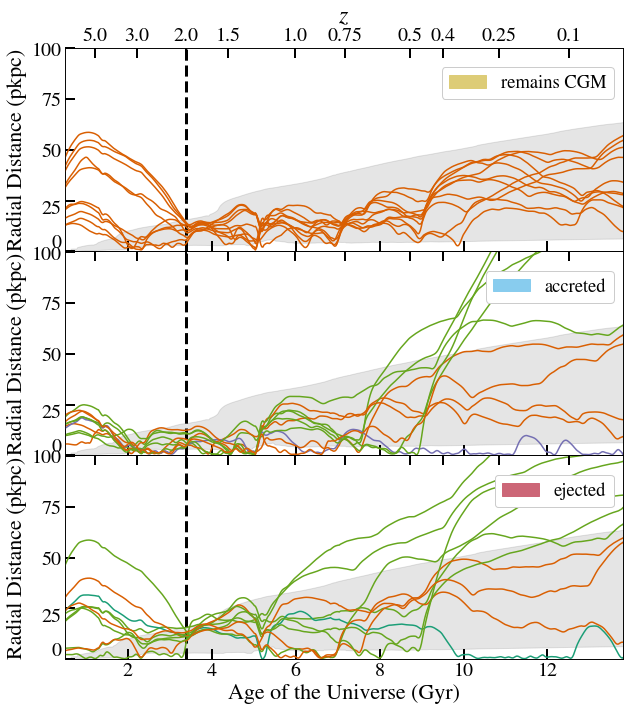

In [33]:
fig = plt.figure( figsize=(10,15), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( 4, 1 )

y_maxes = []
for i, classification in enumerate( used_classification_list ):
    
    # Minor category, skip
    if classification == 'is_CGM_halo_transfer':
        continue
    
    ax = plt.subplot(gs[i,0])
    
#     if ax.is_first_row():
#         ax.annotate(
#             s = m_plot_label,
#             xy = (0,1.1),
#             xycoords = 'axes fraction',
#             va = 'bottom',
#             fontsize = 24,
#         )
    if classification == 'is_CGM_IP':
        ax.annotate(
            s = m_plot_label,
            xy = (0.05,0.95),
            xycoords = 'axes fraction',
            va = 'top',
            fontsize = 24,
        )
    
    gs.update(wspace=0.025, hspace=0.0001)
    
    w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )
    
    class_y_max = w_plotter.plot_streamlines_vs_time(
        y_key = 'R',
        classification = classification,
        classification_ind = ind,
        start_ind = 0,
        end_ind = 595,
        sample_size = 10,
        y_data_kwargs = { 'smooth_data' : True },
        ax = ax,
        x_range = [0.5, 13.8 ],
        y_range = [0., 550, ],
        horizontal_line_value = None,
        plot_CGM_region = True,
        CGM_region_alpha = 0.1,
        return_y_max = True,
        classifications_to_color_on = p_constants.CLASSIFICATIONS_LOCATION,
        ctco_ind = 0,
#         line_features = {
#             'is_class': {
#                 'key': classification,
#                 'value': True,
#                 'data_kwargs': {},
#                 'line_attrs': {
#                     'linewidth': 3,
#                     'color': p_constants.CLASSIFICATION_COLORS_B[classification],
#                     },
#             },
#             'is_gas': {
#                 'key': classification,
#                 'value': False,
#                 'data_kwargs': {},
#                 'line_attrs': {
#                     'linewidth': 1,
#                     'color': p_constants.CLASSIFICATION_COLORS_B[classification],
#                     'linestyle': '--',
#                     },
#                 }
#         },
    )
    y_maxes.append( class_y_max )
        
    # Make virtual artists to allow a legend to appear
    labels = []
    color_objects = []
    color_object = matplotlib.patches.Rectangle(                         
        (0, 0),                                                          
        1,                                                               
        1,                                                               
        fc = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        ec = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        alpha = p_constants.CLASSIFICATION_ALPHA,                        
    )                                                                    
    color_objects.append( color_object )                                 
    labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
    
    # Plot the outer edge of the galaxy under galdefv2
#     ax.plot( w.get_data( 'time')[:r_gal.size], w.r_gal, color='k', linewidth=3.5 )

    # Legend
    l = ax.legend(
        color_objects,
        labels,
        prop={'size': 18.5},
        ncol=1,
        bbox_to_anchor=(1, 0.95),
        loc='upper right',
        fontsize=20,
        framealpha=1.,
    )
    l.set_zorder( 200. )
        
# Changes to axes
for i, classification in enumerate( used_classification_list ):
    
    ax = plt.subplot(gs[i,0])
    ax.set_ylim( 0, 1.05*y_max )
    
    # Add redshift to the axis
    ax2 = plotting.add_redshift_to_axis(
        ax,
        hubble = w.ptracks.data_attrs['hubble'],
        omega_matter = w.ptracks.data_attrs['omega_matter'],
        tick_redshifts = np.array([ 0.1, 0.25, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 5, ])
    )
    
    # Change tick orientation
    ax.tick_params( direction='in' )
    ax2.tick_params( direction='in' )
    
    # Hide overlapping labels
    if not ax.is_first_row():
        ax2.xaxis.set_ticklabels([])
    if not ax.is_last_col():
        ax.xaxis.set_ticklabels([])
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[1].set_verticalalignment( 'top' )
    
    # X label
    if ax2.is_first_row():
        ax2.set_xlabel( r'$z$', fontsize=24 )
        
save_file = 'r_vs_time_{}.pdf'.format( defaults['tag'] )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

fig

## Plot for Final Fate

In [34]:
w.data_masker.clear_masks( True )

In [35]:
# Get the non-empty regions to plot

used_classifications = []
for region in p_constants.CLASSIFICATIONS_LOCATION:
    gas_mass = w.get_selected_quantity( selection_routine=region, ptype='gas' )[0]
    
    if gas_mass > 0.:
        used_classifications.append( region )

In [36]:
# Remove less-important classifications
for c in [ 'is_in_galaxy_halo_interface', 'is_in_other_CGM_not_main' ]:
    if c in used_classifications:
        used_classifications.remove( c )

In [37]:
# Make sure we only select material that's in the CGM...
is_in_CGM_not_sat_at_ind = w.get_processed_data( 'is_in_CGM_not_sat', sl=(slice(None),ind), )
is_in_CGM_not_sat_at_ind_tiled = np.tile( is_in_CGM_not_sat_at_ind, ( w.n_snaps, 1 ) ).transpose()

w.data_masker.mask_data(
    'is_in_CGM_not_sat',
    custom_mask = np.invert( is_in_CGM_not_sat_at_ind_tiled ),
    optional_mask = True,
    mask_name = 'is_in_CGM_not_sat',
)

In [38]:
w.data_masker.clear_masks()

# Make sure we're only truly selecting particles that are in the CGM at the target z

In [39]:
sim_customs = {
    'seed': {
        'm12i': 3,
        'm11q': 14,
        'm10y': 2,
    },
    'label_args': {
        'is_CGM_accreted': {
            'ax': {
                'm12i': 0,
                'm11q': 1,
                'm10y': 1,
            },
            'xy': {
                'm12i': [ 6.2, 190, ],
                'm11q': [ 6., 125, ],
                'm10y': [ 10., 40, ],
            }
        },
        'is_CGM_accreted_to_satellite': {
            'ax': {
                'm12i': 0,
                'm11q': 1,
                'm10y': 0,
            },
            'xy': {
                'm12i': [ 1, 200, ],
                'm11q': [ 10., 135, ],
                'm10y': [ 6., 125, ],
            },
            'custom_label': 'accreted -\nsatellite',
        },
        'is_CGM_ejected': {
            'ax': {
                'm12i': 1,
                'm11q': 0,
                'm10y': 0,
            },
            'xy': {
                'm12i': [ 5.3, 300, ],
                'm11q': [ 5., 115, ],
                'm10y': [ 4., 42.5, ],
            },
        },
    },
}

is_in_main_gal
is_in_CGM
is_in_IGM
File saved at /home1/03057/zhafen/papers/CGM_fate/figures/r_vs_time_eventual_m10y_CGM_snum172.pdf


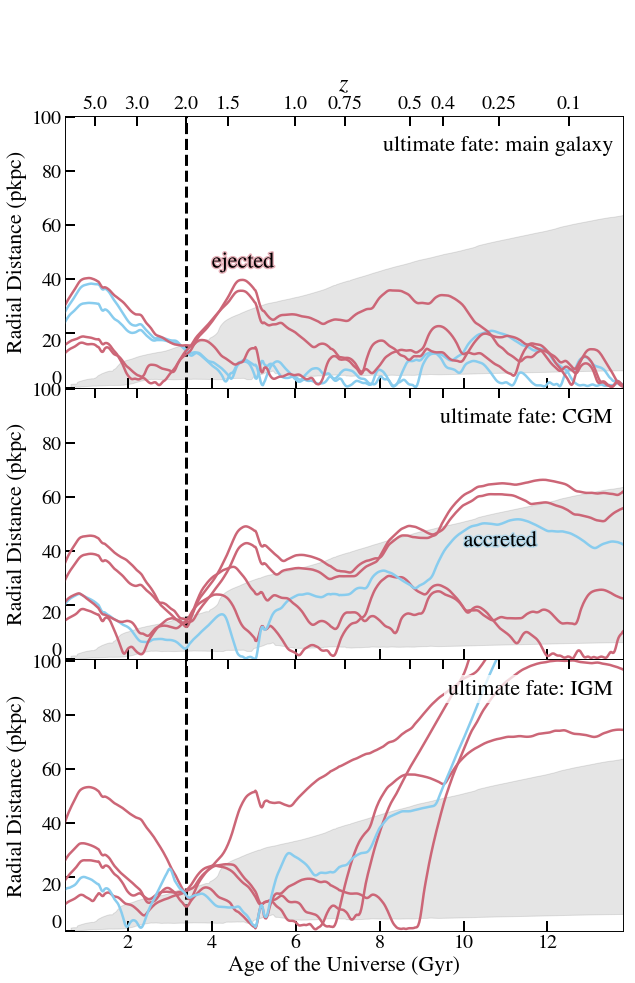

In [40]:
n_rows = len( used_classifications )

fig = plt.figure( figsize=(10,5*n_rows), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1 )

np.random.seed( sim_customs['seed'][sim_name] )

y_maxes = []
for i, classification in enumerate( used_classifications ):
    
    print( classification )
    
    ax = plt.subplot(gs[i,0])

    if classification == 'is_CGM_IP':
        ax.annotate(
            s = m_plot_label,
            xy = (0.05,0.95),
            xycoords = 'axes fraction',
            va = 'top',
            fontsize = 24,
        )
    
    gs.update(wspace=0.025, hspace=0.0001)
    
    w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )
            
    # Add annotations
    label_classifications = [ 'is_CGM_accreted', 'is_CGM_accreted_to_satellite', 'is_CGM_ejected', ]
    for k, l_c in enumerate( label_classifications ):

        if i != sim_customs['label_args'][l_c]['ax'][sim_name]:
            continue
        
        label_args = {
            's' : p_constants.CLASSIFICATION_LABELS[l_c],
            'fontsize' : 22,
            'color' : 'k',
            'va': 'bottom',
            'xycoords': 'data',
        }
        label_args['xy'] = sim_customs['label_args'][l_c]['xy'][sim_name]
        if 'custom_label' in sim_customs['label_args'][l_c]:
            label_args['s'] = sim_customs['label_args'][l_c]['custom_label']

        text = ax.annotate( **label_args )

        text.set_path_effects([
            path_effects.Stroke(
                linewidth=3, 
                foreground=config.COLORSCHEME[l_c],
                alpha = 0.5,
            ),
            path_effects.Normal(),
        ])
    
    class_y_max = w_plotter.plot_streamlines_vs_time(
        y_key = 'R',
        classification = classification,
        classification_ind = 0,
        optional_masks = [ 'is_in_CGM_not_sat' ],
        start_ind = 0,
        end_ind = 595,
        sample_size = 5,
        y_data_kwargs = { 'smooth_data' : True },
        ax = ax,
        x_range = [0.5, 13.8 ],
        y_range = [0., 550, ],
        vert_line_ind = ind,
        horizontal_line_value = None,
        plot_CGM_region = True,
        CGM_region_alpha = 0.1,
        return_y_max = True,
        classifications_to_color_on = p_constants.CLASSIFICATIONS_CGM_FATE,
        ctco_ind = ind,
        linewidth = 2.5,
#         line_features = {
#             'is_class': {
#                 'key': classification,
#                 'value': True,
#                 'data_kwargs': {},
#                 'line_attrs': {
#                     'linewidth': 3,
#                     'color': p_constants.CLASSIFICATION_COLORS_B[classification],
#                     },
#             },
#             'is_gas': {
#                 'key': classification,
#                 'value': False,
#                 'data_kwargs': {},
#                 'line_attrs': {
#                     'linewidth': 1,
#                     'color': p_constants.CLASSIFICATION_COLORS_B[classification],
#                     'linestyle': '--',
#                     },
#                 }
#         },
    )
    y_maxes.append( class_y_max )
    
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    ax.annotate(
        s = 'ultimate fate: {}'.format( p_constants.CLASSIFICATION_LABELS[classification] ),
        xy = ( 1., 1. ),
        xytext = ( -10, -20 ),
        va = 'top',
        ha = 'right',
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        fontsize = 22,
        zorder = 1000,
        bbox = bbox_props,
    )
        
# Changes to axes
for i, classification in enumerate( used_classifications ):
    
    ax = plt.subplot(gs[i,0])
    ax.set_ylim( 0, 1.05*y_max )
    
    # Add redshift to the axis
    ax2 = plotting.add_redshift_to_axis(
        ax,
        hubble = w.ptracks.data_attrs['hubble'],
        omega_matter = w.ptracks.data_attrs['omega_matter'],
        tick_redshifts = np.array([ 0.1, 0.25, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 5, ])
    )
    
    # Change tick orientation
    ax.tick_params( direction='in' )
    ax2.tick_params( direction='in' )
    
    # Hide overlapping labels
    if not ax.is_first_row():
        ax2.xaxis.set_ticklabels([])
    if not ax.is_last_col():
        ax.xaxis.set_ticklabels([])
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[1].set_verticalalignment( 'top' )
    
    # X label
    if ax2.is_first_row():
        ax2.set_xlabel( r'$z$', fontsize=24 )
        
save_file = 'r_vs_time_eventual_{}.pdf'.format( defaults['tag'] )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

fig

In [41]:
plt.close( 'all' )